# GEM ML Framework Demonstrator - Water Segmentation
In these notebooks, we will get a feeling of how the GEM ML framework can be used for the segmentation of water bodies using Sentinel-1 imagery as input and Sentinel-2 based normalised difference water index (NDWI) as a reference.
The idea is to use a neural network (NN) model for the analysis.
Thanks to the flexibility of the GEM ML framework, the model used can be replaced by changing the configuration only.
We will have a look at the following notebooks separately:
- 00_Configuration
- 01_DataAcquisition
- 02_DataNormalisation
- 03_TrainingValidationTesting
- 04_PyTorchTasks_ModelForwardTask
- 05_PyTorchTasks_FeatureAttributionTasks
- 06_PyTorchTasks_UncertaintyQuantificationTasks
- 07_PyTorchTasks_DimensionalityReductionTasks

by Michael Engel (m.engel@tum.de)

-----------------------------------------------------------------------------------

# PyTorchTasks - ModelForwardTask
In this notebook, we see, how the GEM ML Framework can support decision making such as for flood disasters.
The scenario is a flood event where no reference data is available as too many clouds occured.
Hence, we need a fast and reliable map of the water body!
For that purpose, a fast inference pipeline is necessary.
The `PyTorchTasks` provide the `ModelForwardTask` for that purpose.
It enables the users to integrate an already trained PyTorch-model into their eo-learn workflows.
The management of GPU/CPU shifting is done by the ExecuteME package we provide for that purpose.
In general, we do recommend to do this in common Python scripts as jupyter notebooks do not support the spawn method for parallelization which PyTorch-objects ask for.

In [1]:
import os
import sys
import platform
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import time
import natsort

import torch
import torch.multiprocessing as mp
from tensorboardX import SummaryWriter
from tensorboard import notebook

from sentinelhub import SHConfig, BBox, CRS, DataCollection, UtmZoneSplitter, DataCollection
from eolearn.core import FeatureType, EOPatch, MergeEOPatchesTask, MapFeatureTask, MergeFeatureTask, ZipFeatureTask, LoadTask, EONode, EOWorkflow, EOExecutor, OverwritePermission, SaveTask
from eolearn.io import SentinelHubDemTask, ExportToTiffTask, SentinelHubInputTask, SentinelHubEvalscriptTask, get_available_timestamps
from eolearn.mask import CloudMaskTask, JoinMasksTask

import rasterio
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon,Point
import folium
from folium import plugins as foliumplugins

from libs.ConfigME import Config, importME
from libs.MergeTDigests import mergeTDigests
from libs.QuantileScaler_eolearn import QuantileScaler_eolearn_tdigest
from libs.Dataset_eolearn import Dataset_eolearn
from libs import AugmentME
from libs import ExecuteME

from tasks.TDigestTask import TDigestTask
from tasks.PickIdxTask import PickIdxTask
from tasks.SaveValidTask import SaveValidTask
from tasks.PyTorchTasks import ModelForwardTask

from utils.rasterio_reproject import rasterio_reproject
from utils.transforms import batchify, predict, mover, Torchify
from utils.parse_time_interval_observations import parse_time_interval_observations

print("Working Directory:",os.getcwd())
print("Environment:",os.environ['CONDA_DEFAULT_ENV'])
print("Executable:",sys.executable)

C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Incorporating libs!
Incorporating tasks!
Incorporating utils!
Working Directory: D:\OneDrive\Offiziell\Promotion\Code\Git\eo-learn-examples\GEM-ML\Example_WaterSegmentation
Environment: eolearn_water
Executable: C:\Users\skryp\miniconda3\envs\eolearn_water\python.exe


# Config
First, we load our configuration file which provides all information we need throughout the script.

In [2]:
#%% load configuration file
config = Config.LOAD("config.dill")
config.linuxify()

# Area of Interest
Let's load the geojson of our area of interests for decision making.

In [3]:
#%% load geojson files
aoi_showcase = gpd.read_file(config['AOI_showcase'])

#%% find best suitable crs and transform to it
crs_showcase = aoi_showcase.estimate_utm_crs()
aoi_showcase = aoi_showcase.to_crs(crs_showcase)

In [4]:
#%% calculate and print size
aoi_showcase_shape = aoi_showcase.geometry.values[0]
aoi_showcase_width = aoi_showcase_shape.bounds[2]-aoi_showcase_shape.bounds[0]
aoi_showcase_height = aoi_showcase_shape.bounds[3]-aoi_showcase_shape.bounds[1]
print(f"Dimension of the showcase area is {aoi_showcase_width:.0f} x {aoi_showcase_height:.0f} m2")

#%% create a splitter to obtain a list of bboxes
bbox_splitter_showcase = UtmZoneSplitter([aoi_showcase_shape], aoi_showcase.crs, config["patchpixelwidth"]*config["resolution"])

bbox_list_showcase = np.array(bbox_splitter_showcase.get_bbox_list())
info_list_showcase = np.array(bbox_splitter_showcase.get_info_list())

Dimension of the showcase area is 41086 x 33233 m2


In [5]:
#%% determine number of coordinate reference systems
crss = [bbox_._crs for bbox_ in bbox_list_showcase]
crss_unique = np.array(list(dict.fromkeys(crss)))
n_crss = len(crss_unique)

#%% sort geometries and indices by crs and store to disk
geometries = [[] for i in range(n_crss)]
idxs = [[] for i in range(n_crss)]
idxs_x = [[] for i in range(n_crss)]
idxs_y = [[] for i in range(n_crss)]
for i,info in enumerate(info_list_showcase):
    idx_ = np.argmax(crss_unique==bbox_list_showcase[i]._crs)

    geometries[idx_].append(Polygon(bbox_list_showcase[i].get_polygon())) # geometries sorted by crs
    idxs[idx_].append(info["index"]) # idxs sorted by crs
    idxs_x[idx_].append(info["index_x"]) # idxs_x sorted by crs
    idxs_y[idx_].append(info["index_y"]) # idxs_y sorted by crs

tiles = []
for i in range(n_crss):
    #%%% build dataframe of our areas of interest (and each crs)
    tiles.append(
        gpd.GeoDataFrame(
            {"index": idxs[i], "index_x": idxs_x[i], "index_y": idxs_y[i]},
            crs="EPSG:"+crss_unique[i]._value_,
            geometry=geometries[i]
        )
    )
    #%%% save dataframes to shapefiles
    tiles[-1].to_file(os.path.join(config["dir_results"],f"grid_aoi_showcase_{i}_EPSG{str(crss_unique[i]._value_)}.gpkg"), driver="GPKG")

In [6]:
#%% print amount of patches
print("Total number of tiles:",len(bbox_list_showcase))

#%% visualize using folium
aoi_folium = aoi_showcase.to_crs("EPSG:4326")
location = [aoi_folium.centroid.y,aoi_folium.centroid.x]

mapwindow = folium.Map(location=location, tiles='Stamen Terrain', zoom_start=8)

#%%% add aois
#%%%% train
mapwindow.add_child(
    folium.features.Choropleth(
        aoi_folium.to_json(),
        fill_color="royalblue",
        nan_fill_color="royalblue",
        fill_opacity=0,
        nan_fill_opacity=0.5,
        line_color="royalblue",
        line_weight=1,
        line_opacity=0.6,
        smooth_factor=5,
        name=f"showcase area"
    )
)

#%%% add grids in color
for t_,tiles_ in enumerate(tiles):
    cp = folium.features.Choropleth(
            tiles_.to_crs("EPSG:4326").to_json(),
            fill_color="royalblue",
            nan_fill_color="black",
            fill_opacity=0,
            nan_fill_opacity=0.5,
            line_color="royalblue",
            line_weight=0.5,
            line_opacity=0.6,
            smooth_factor=5,
            name=f"showcase grid EPSG:{crss_unique[t_]._value_}"
        ).add_to(mapwindow)

    # display index next to cursor
    folium.GeoJsonTooltip(
        ['index'],
        aliases=['Index:'],
        labels=False,
        style="background-color:rgba(0,101,189,0.4); border:2px solid white; color:white;",
        ).add_to(cp.geojson)

#%%% add some controls
folium.LayerControl().add_to(mapwindow)
foliumplugins.Fullscreen(force_separate_button=True).add_to(mapwindow)

#%%% save, render and display
mapwindow.save(os.path.join(config["dir_results"],'gridmap_showcase.html'))
mapwindow.render()
mapwindow

Total number of tiles: 63


C:\Users\skryp\AppData\Local\Temp\ipykernel_13916\2758186615.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  location = [aoi_folium.centroid.y,aoi_folium.centroid.x]
C:\Users\skryp\AppData\Local\Temp\ipykernel_13916\2758186615.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  location = [aoi_folium.centroid.y,aoi_folium.centroid.x]


# Showcase Tasks
Let's define our `EOTasks`.

## Input Tasks
Of course, we have to start with our input tasks which are the same as for the training, validation and testing procedure.
Only, we skip the checking and the reference (as the area is too cloudy).

In [7]:
#%% Sentinel-Hub-Input-Task
task_data = SentinelHubInputTask(
    data_collection = DataCollection.SENTINEL1_IW,
    size = None,
    resolution = config["resolution"],
    bands_feature = (FeatureType.DATA, "data"),
    bands = None,
    additional_data = (FeatureType.MASK, "dataMask", "dmask_data"),
    evalscript = None,
    maxcc = None,
    time_difference = dt.timedelta(hours=1),
    cache_folder = config["dir_cache"],
    max_threads = config["threads"],
    config = config["SHconfig"],
    bands_dtype = np.float32,
    single_scene = False,
    mosaicking_order = "mostRecent",
    aux_request_args = None
)

## PyTorch Tasks
As discussed, we want to respond to the disaster immediately.
That means, we want to use our trained, validated and tested model for prediction!
Fortunately, TUM established the `PyTorchTask` as a base class for many PyTorch related `EOTasks` like the `ModelForwardTask`, the `LayerGradCamTask` or the `GradientShapTask`, for example.
In this notebook, we focus on the `ModelForwardTask`.

### Model
As a first step, however, we need to load our Scaler as built in [02_DataNormalization]() again and implement a functionality for returning the prediction of our model as the forward does return the logits and not the final prediction.
By that, we ensure that the input feature is fed to our model and the water mask is returned as intended.

In [8]:
Scaler = QuantileScaler_eolearn_tdigest.LOAD(os.path.join(config["dir_results"],config["savename_scaler"]))

As a second, we load our best model using the `BaseClass` by AugmentME.
Further, we set it to evaluation mode and tell it to share its memory for being deployed on multiple CPUs.
It is important to load the model to the `CPU` as you get in trouble with the parallelization of ExecuteME otherwise.

In [9]:
model = AugmentME.BaseClass(mode="torch")
model.load(os.path.join(config["dir_results"],config["model_savename_bestloss"]),device="cpu")
model.eval()
model.share_memory()

loadME_torch: start loading of the entire model!
loadME_torch: loaded


DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

### ModelForwardTask
Now, it is time to define the `ModelForwardTask` which does the computation for us!
As for all `EOTasks` we choose the in- and output features.
The `in_feature` is fed to the model whereas its result is stored in the `out_feature`.
In order to properly normalize the data downloaded we have to insert our scaler for `in_transform`.
Since we are interested in the predicted water mask, we have to insert our prediction transform for `out_transform`.

In [10]:
task_model = ModelForwardTask(
    in_feature = (FeatureType.DATA,"data"),
    out_feature = (FeatureType.MASK,"model_output"),
    model = model,

    in_transform = Scaler,
    out_transform = predict,
    in_torchtype = torch.FloatTensor,
    batch_size = config["max_batch_size"],

    maxtries=3,
    timeout=22,
)

## Export Tiffs and Saving Tasks
Of course, we want to export the model output as a GeoTiff such that others can have a look at it using common GIS software.
We can use the [`ExportToTiffTask`](https://eo-learn.readthedocs.io/en/latest/reference/eolearn.io.raster_io.html#eolearn.io.raster_io.ExportToTiffTask) for that.

In [11]:
task_tiff = ExportToTiffTask(
    feature = (FeatureType.MASK,"model_output"),
    folder = config["dir_tiffs_showcase"],
    date_indices = None,
    band_indices = None,
    crs = None,
    fail_on_missing = True,
    compress = "deflate"
)

Finally, we want to store the resulting patches, of course!

In [12]:
#%% save EOPatches
task_save = SaveTask(
    path = config["dir_data"],
    filesystem = None,
    config = config["SHconfig"],
    overwrite_permission = OverwritePermission.OVERWRITE_PATCH,
    compress_level = 2
)

# Workflow
As usually, we start defining our nodes!

In [13]:
#%% input nodes
node_data = EONode(
    task = task_data,
    inputs = [],
    name = "load Sentinel-1 data"
)

#%% inference node
node_model = EONode(
    task = task_model,
    inputs = [node_data],
    name = "predict water mask"
)

#%% export and save
node_tiff = EONode(
    task = task_tiff,
    inputs = [node_model],
    name = "export GeoTiff of model output"
)

node_save = EONode(
    task = task_save,
    inputs = [node_tiff],
    name = "save EOPatch"
)

Finally, we can define our workflow from endnode!

In [14]:
workflow = EOWorkflow.from_endnodes(node_save)
#workflow.dependency_graph()

# Execution
We want to execute our workflow in parallel.
This can be done using the package ExecuteME.

In the following, we have to ensure the entry point by asking the file defining the subprocesses to be the main file since PyTorch models demand the spawn start method for subprocesses.
Hence, we do recommend to do this in common Python scripts as jupyter notebooks ask you to clarify the entry point in every cell.
Still, the parallelization does not work in jupyter notebooks but you may let it run using one worker.

## Workflow Arguments
On a first stage, we have to define the standard workflow arguments, both temporal and spatially.
Note that we only want to download the data which does not exist on our device.
Hence, we check for existence first and assign arguments afterwards.

In [23]:
if __name__=='__main__':  
    #%% define workflow arguments
    workflow_args = []
    bbox_list_ = bbox_list_showcase
    for i in range(len(bbox_list_)):
        print(f"\rChecking workflow args {i+1}/{len(bbox_list_)}",end="\r")
        try:
            #%%% query available timestamps
            timeinterval = parse_time_interval_observations(
                time_interval = (config["n_observations_showcase"],config["end_showcase"]),
                bbox = bbox_list_[i],
                data_collection = DataCollection.SENTINEL1_IW,
                check_timedelta = config["checktimedelta_showcase"],
                include_borders = True,
                time_difference = dt.timedelta(seconds=0),
                maxcc = None,
                config = config["SHconfig"]
            )
            timeintervalstring = f"{timeinterval[0].strftime(r'%Y-%m-%dT%H-%M-%S_%Z')}--{timeinterval[1].strftime(r'%Y-%m-%dT%H-%M-%S_%Z')}"
            dir_ = f"showcase/eopatch_{i}_{timeintervalstring}"
            if not os.path.exists(os.path.join(config["dir_data"],dir_)):### and False: ### 
                workflow_args.append(
                    {
                        node_data: {"bbox":bbox_list_[i],"time_interval":timeinterval},
                        node_tiff: {"filename": f"water_{i}_{timeintervalstring}"},
                        node_save: {"eopatch_folder":dir_}
                    }
                )
        except Exception as e:
            print(e,timeinterval)
    print()

    print(f"Number of downloads/calculations: {len(workflow_args)}")

parse_time_interval_observations: not enough observations found - returning checkinterval!
parse_time_interval_observations: not enough observations found - returning checkinterval!
parse_time_interval_observations: not enough observations found - returning checkinterval!
parse_time_interval_observations: not enough observations found - returning checkinterval!
parse_time_interval_observations: not enough observations found - returning checkinterval!
parse_time_interval_observations: not enough observations found - returning checkinterval!
parse_time_interval_observations: not enough observations found - returning checkinterval!
parse_time_interval_observations: not enough observations found - returning checkinterval!
parse_time_interval_observations: not enough observations found - returning checkinterval!
parse_time_interval_observations: not enough observations found - returning checkinterval!
parse_time_interval_observations: not enough observations found - returning checkinterval!

## Devices
Second, we have to initialize a multiprocessing queue containing the names of our devices!
By that we could use an arbitrary amount of GPUs.
Of course, it is possible, to stay on the CPU by setting the config.device accordingly.

The `PyTorchTasks` are designed for features containing multiple timestamps to be analyzed.
Accordingly, the `batch_size` parameter of the `ModelForwardTask` refers to the timestamps, i.e. the first dimension of a feature array.
If you do not have multiple timestamps, you may insert some kind of `batch_size` for one device by defining `batch_size x available_devices` devices or in particular `batch_size` times the device you want to use multiple times.
Please be careful doing that since there is an additional cost of initialising the model per patch then.
That is, the model is not shared between multiple `EOPatches`.
Still, that behavior is beneficial if some analysis using the `ModelUncertaintyTask` is to be done.
Here, it is necessary to deploy the model multiple times, anyway.

In [24]:
if __name__=='__main__':  
    devices = ExecuteME.Devices(["cuda"],multiprocessing_context="spawn")

In a next step, we will define the multiprocessing-type-keyword-arguments which have to be given to our tasks separately.
These keyword-arguments have to be shared between the processes as the list of available devices should be known by the different workes and, hence, be shared or provided separately.

In [25]:
if __name__=='__main__':  
    mpkwargs = {
        node_model: {"devices":devices},
    }

## Run
Now, it's time to let it run!
Please notice that we insert a 0 for `threads` since jupyter notebooks do not allow for the spawn method.
In a Python script, you may choose as many threads as you like.

In [26]:
if __name__=='__main__':  
    start_multi = time.time()
    results_multi = ExecuteME.execute(
        fun = workflow.execute,
        kwargslist = workflow_args,
        mpkwargs = mpkwargs,
        kwargsmode = None,
        resultsqueue = None,
        NoReturn = True,
        timeout = 1,
        threads = 0,#config["threads"],
        checkthreads = True,
        multiprocessing_context = "spawn",
        multiprocessing_mode = "std",
        bequiet = False
    )
    time_multi = time.time()-start_multi

    #%%% results
    print(f"Time Multi:\t\t{time_multi}s")

C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(
C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(
C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(
C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(
C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(
C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


63/63 calculations [100.00%] with 1 thread(s)	

Time Multi:		295.72664737701416s


C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\eolearn\io\raster_io.py:263: EORuntimeWarning: Data from feature (<FeatureType.MASK: 'mask'>, 'model_output') cannot be exported to tiff with dtype numpy.int64. Will export as numpy.int32 instead
  warnings.warn(


## Downloaded Data
Let's have a look how many `EOPatches` got stored to disk.

In [27]:
print(f"Number of showcasedownloads: {len(workflow_args)}")
print(f"Number of stored showcase EOPatches: {len(os.listdir(config['dir_showcase']))}")

Number of showcasedownloads: 63
Number of stored showcase EOPatches: 63


We finally made it!
Everything is ready for being analysed!

# Analysis
As a first analysis step, we want to merge all of our computed GeoTiffs.

In [28]:
config.importME("../utils/RasterME_merge.raster_merge")(
    inputfiles = [os.path.join(config["dir_tiffs_showcase"],dir_) for dir_ in os.listdir(config["dir_tiffs_showcase"]) if "water" in dir_.split("_")],
    outputfile = os.path.join(config["dir_results"],config["savename_showcase_tiff"]),
    format_option = 'COMPRESS=Deflate',
    sparse = True,
    #nmax_files = 10
)

0

For the purpose of visualization, rather often, we need our results in EPSG:4326.
Accordingly, we reproject it.

In [29]:
rasterio_reproject(
    inputfile = os.path.join(config["dir_results"],config["savename_showcase_tiff"]),
    outputfile = os.path.join(config["dir_results"],config["savename_showcase_tiff_reproject"]),
    crs_target = 'EPSG:4326',
    compression = "deflate"
)

True

Let's have a look at the water mask on our map!
As additional layers, we use some WMTS-layers we [defined in our Sentinel-Hub configuration](TODO).

C:\Users\skryp\AppData\Local\Temp\ipykernel_13916\3433309796.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  location = [aoi_folium.centroid.y,aoi_folium.centroid.x]
C:\Users\skryp\AppData\Local\Temp\ipykernel_13916\3433309796.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  location = [aoi_folium.centroid.y,aoi_folium.centroid.x]



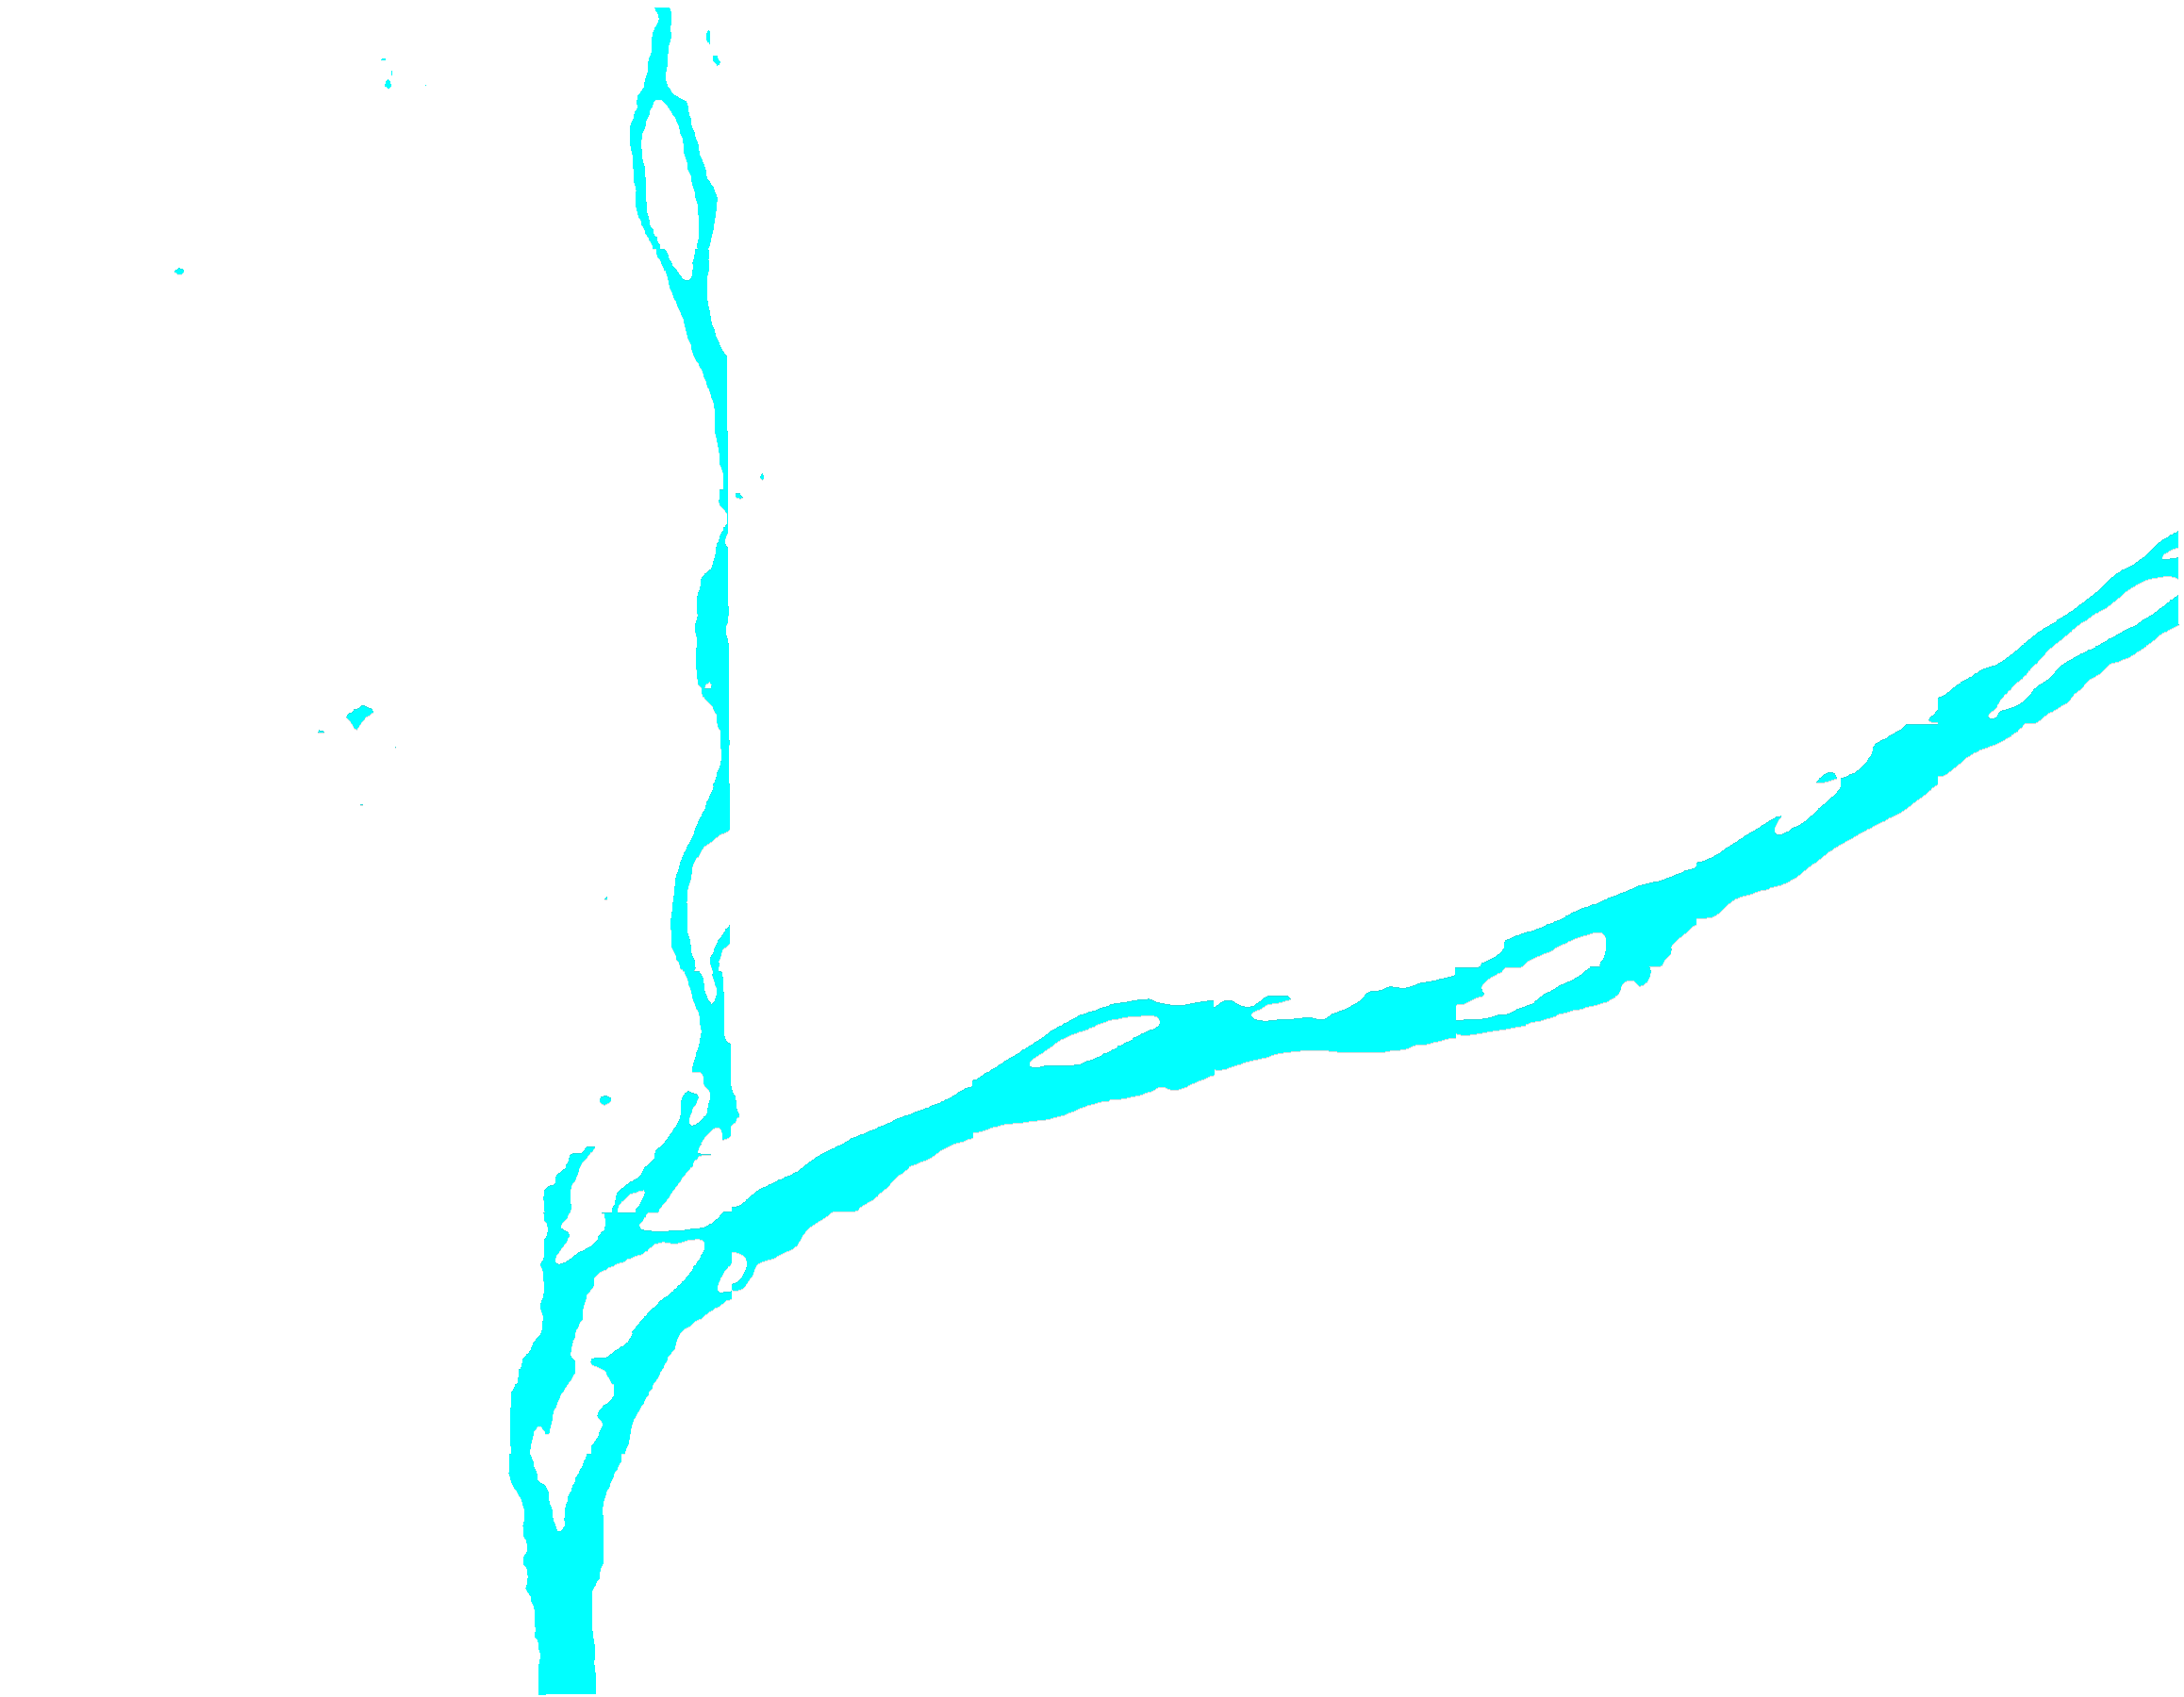

In [30]:
#%% visualize using folium
#%%% predefine
aoi_folium = aoi_showcase.to_crs("EPSG:4326")
location = [aoi_folium.centroid.y,aoi_folium.centroid.x]

riofile = rasterio.open(os.path.join(config["dir_results"],config["savename_showcase_tiff_reproject"]))
img = riofile.read().transpose(1,2,0)
maxwateridx = np.argmax(np.sum(img,axis=(0,1)))
img = img[...,[maxwateridx]]
img = np.concatenate([0/255*img,101/255*img,189/255*img,0.3*img],axis=-1)

#%%% initialize window
mapwindow = folium.Map(location=location, tiles='OpenStreetMap', zoom_start=10)

#%%% add WMTS layer
#%%%% Sentinel-2 True Color
wms1 = folium.WmsTileLayer(
    f'https://services.sentinel-hub.com/ogc/wms/cea3abac-212c-45de-a69a-c6d613fb372e?Time={config["end_showcase"].strftime("%Y-%m-%d")}',
    name='Sentinel-2 True Color',
    styles='',
    fmt='image/jpg',
    transparent=True,
    layers='TRUE_COLOR_VISUALIZATION,DATE',
    overlay = True,
    control = True,
    show = False
).add_to(mapwindow)

#%%%% Sentinel-2 SWIR
wms2 = folium.WmsTileLayer(
    f'https://services.sentinel-hub.com/ogc/wms/cea3abac-212c-45de-a69a-c6d613fb372e?Time={config["end_showcase"].strftime("%Y-%m-%d")}',
    name='Sentinel-2 SWIR',
    styles='',
    fmt='image/jpg',
    transparent=True,
    layers='SWIR_VISUALIZATION,DATE',
    overlay = True,
    control = True,
    show = False
).add_to(mapwindow)

#%%%% Sentinel-1
wms3 = folium.WmsTileLayer(
    f'https://services.sentinel-hub.com/ogc/wms/cea3abac-212c-45de-a69a-c6d613fb372e?Time={config["end_showcase"].strftime("%Y-%m-%d")}',
    name='Sentinel-1',
    styles='',
    fmt='image/jpg',
    transparent=True,
    layers='SENTINEL-1_IW_VIS2,DATE',
    overlay = True,
    control = True,
    show = False
).add_to(mapwindow)

#%%%% Add WmsTileLayers to time control.
time = foliumplugins.TimestampedWmsTileLayers(
    data=[wms1,wms2,wms3],
    transition_time=24*3600*1000,
    loop=False,
    auto_play=False,
    period='P1D',
    time_interval=False,
    name=None
).add_to(mapwindow)


#%%% add water mask to map
folium.raster_layers.ImageOverlay(
    image = img,
    bounds = [[riofile.bounds.bottom,riofile.bounds.left],
              [riofile.bounds.top,riofile.bounds.right]
             ],
    origin = 'upper',
    colormap = None,
    mercator_project = True,
    pixelated = True,
    name = "WaterMask",
    overlay = True,
    control = True,
    show = True,
    opacity = 0.3
).add_to(mapwindow)

#%%% add some controls
folium.LayerControl().add_to(mapwindow)
foliumplugins.Fullscreen(force_separate_button=True).add_to(mapwindow)

#%%% save, render and display
mapwindow.save(os.path.join(config["dir_results"],'showcase.html'))
mapwindow.render()
mapwindow

Now you know how to use the `ModelForwardTask`! :)